In [1]:
import numpy as np
import uproot as up
import utils
from matplotlib import pyplot as plt
from scipy.linalg import cholesky, sqrtm
from scipy.optimize import minimize
from scipy.stats import norm, rv_histogram

In [2]:
# Unfolded results from https://t2k-experiment.org/results/2018-transverse-cc0pi/
F = up.open("TKI/dptResults_noreg.root")
unfolded_h = F["Result"].to_numpy()
bins = unfolded_h[1]
unfolded_h = (unfolded_h[0] * 1e38, bins)
F = up.open("TKI/dptResults.root")
pre_regularised_h = F["Result"].to_numpy()
pre_regularised_h = (pre_regularised_h[0] * 1e38, bins)

In [3]:
# Nominal MC from https://ora.ox.ac.uk/objects/uuid:16cef4e8-b52b-48c4-a954-81fba0b7536b Figure 9.4
# Extracted with https://apps.automeris.io/wpd/
nominal = np.loadtxt("TKI/dpt-nominal.txt") / 10.0

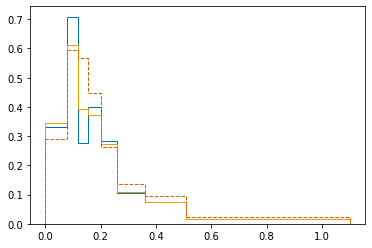

In [4]:
plt.stairs(*unfolded_h)
plt.stairs(*pre_regularised_h)
plt.stairs(nominal, bins, linestyle="dashed")

In [5]:
# Error bars
F = up.open("TKI/dptResults_noreg.root")
cov_unfolded = F["Covariance_Matrix"].to_numpy()[0]
cor_unfolded = cov_unfolded / (
    np.sqrt(np.diag(cov_unfolded))[:, None] * np.sqrt(np.diag(cov_unfolded))[None, :]
)
cov_unfolded_inv = np.linalg.inv(cov_unfolded)
cor_unfolded[~np.isfinite(cor_unfolded)] = 0

F = up.open("TKI/dptResults.root")
cov_pre_regularised = F["Covariance_Matrix"].to_numpy()[0]
cor_pre_regularised = cov_pre_regularised / (
    np.sqrt(np.diag(cov_pre_regularised))[:, None]
    * np.sqrt(np.diag(cov_pre_regularised))[None, :]
)
cov_pre_regularised_inv = np.linalg.inv(cov_pre_regularised)
cor_pre_regularised[~np.isfinite(cor_pre_regularised)] = 0

(
    np.sqrt(np.max(np.diag(cov_unfolded))),
    np.max(cor_unfolded),
    np.min(cor_unfolded),
    np.min(cov_unfolded),
    np.sqrt(np.max(np.diag(cov_pre_regularised))),
    np.max(cor_pre_regularised),
    np.min(cor_pre_regularised),
    np.min(cov_pre_regularised),
)

(0.23052923052360283,
 1.0000000000000002,
 -0.7315042009752449,
 -0.03328873921760593,
 0.12609433271088152,
 1.0000000000000002,
 -0.3601130822204673,
 -0.005602009313643436)

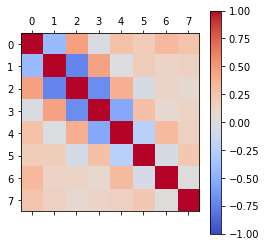

In [6]:
plt.matshow(cor_unfolded, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()

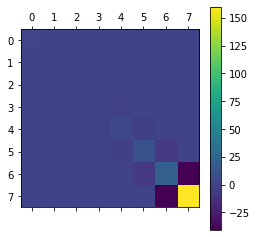

In [7]:
# Regularisation
C = utils.Q1s(nominal)
plt.matshow(C)
plt.colorbar()

In [8]:
# Regularised result
#
# m' = A m
# A = (cov^{-1} + C)^-1 cov^{-1}

tau_list = [0.0] + list(np.logspace(0, 2, 9 + 8))
A_list = [
    np.linalg.inv(cov_unfolded_inv + tau * C) @ cov_unfolded_inv for tau in tau_list
]
regularised_list = [A @ unfolded_h[0] for A in A_list]

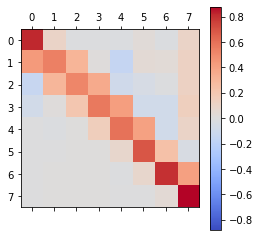

In [9]:
plt.matshow(A_list[-1], cmap="coolwarm", vmin=-np.max(A_list[-1]))
plt.colorbar()

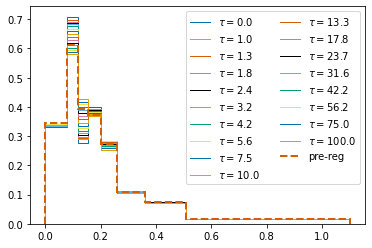

In [10]:
for x, tau in zip(regularised_list, tau_list):
    plt.stairs(x, bins, label=rf"$\tau = {tau:3.1f}$")
plt.stairs(*pre_regularised_h, label="pre-reg", linewidth=2, linestyle="dashed")
plt.legend(ncol=2)

In [11]:
# Metrics
jaggedness = [x.T @ C @ x for x in regularised_list]
bias = [
    (x - unfolded_h[0]).T @ cov_unfolded_inv @ (x - unfolded_h[0])
    for x in regularised_list
]

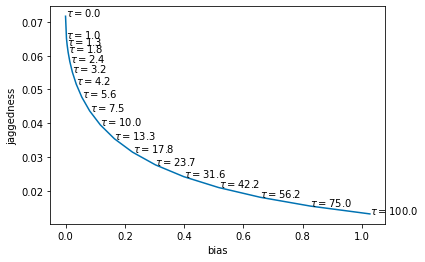

In [12]:
plt.plot(bias, jaggedness)
plt.xlabel("bias")
plt.ylabel("jaggedness")
for x, y, tau in zip(bias, jaggedness, tau_list):
    plt.annotate(rf"$\tau = {tau:.1f}$", (x, y))

In [13]:
# Alt metrics
# Determinant of covariance/correlation matrix as measure of overall correlation?
cov_list = [A @ cov_unfolded @ A.T for A in A_list]
cor_list = [
    np.diag(np.diag(cov) ** (-0.5)) @ cov @ np.diag(np.diag(cov) ** (-0.5))
    for cov in cov_list
]
cov_det_list = [np.linalg.det(cov) for cov in cov_list]
cor_det_list = [np.linalg.det(cor) for cor in cor_list]

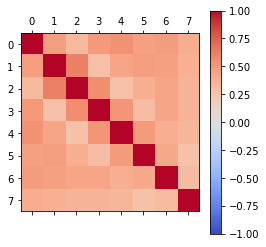

In [14]:
plt.matshow(cor_list[-1], cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()

In [15]:
# Alt metrics
# Wasserstein distance in uncorrelated standard normal space
# The Fréchet distance between multivariate normal distributions
# https://doi.org/10.1016/0047-259X(82)90077-X
dist = []
diag_dist = []


def wasserstein(x, cov, base_x=unfolded_h[0], base_cov=cov_unfolded):
    U = cholesky(np.linalg.inv(base_cov))
    m = U @ base_x
    diff = m - U @ x
    S = U @ cov @ U.T
    d = diff.T @ diff + cov.shape[0] + np.trace(S - 2 * sqrtm(S))
    return abs(d)  # Catch some numerical issues


for x, cov in zip(regularised_list, cov_list):
    # Distance between original and regularised
    dist.append(wasserstein(x, cov))
    # Distance between original and plot
    diag_dist.append(wasserstein(x, np.diag(np.diag(cov))))

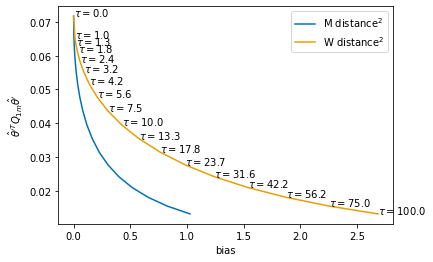

In [16]:
plt.plot(bias, jaggedness, label="M distance$^2$")
plt.plot(dist, jaggedness, label="W distance$^2$")
plt.legend()
plt.xlabel("bias")
plt.ylabel(r"${\hat\theta}'^T Q_{1m} {\hat\theta}'$")
for x, y, tau in zip(dist, jaggedness, tau_list):
    plt.annotate(rf"$\tau = {tau:.1f}$", (x, y))
plt.savefig("figures/L-curve.pdf")

13 31.622776601683793 2.0820378778084505 1.4429268442330854


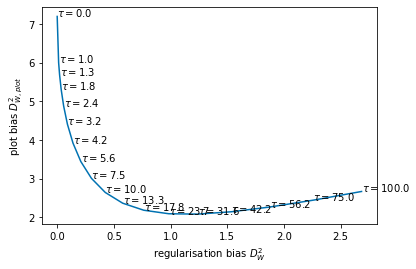

In [17]:
plt.plot(dist, diag_dist)
plt.xlabel("regularisation bias $D^2_W$")
plt.ylabel("plot bias $D^2_{W,plot}$")
i_W = 0
best = np.inf
for i, (x, y, tau) in enumerate(zip(dist, diag_dist, tau_list)):
    plt.annotate(rf"$\tau = {tau:.1f}$", (x, y))
    if y < best:
        best = y
        i_W = i
plt.savefig("figures/plot-L-curve.pdf")
print(i_W, tau_list[i_W], best, np.sqrt(best))

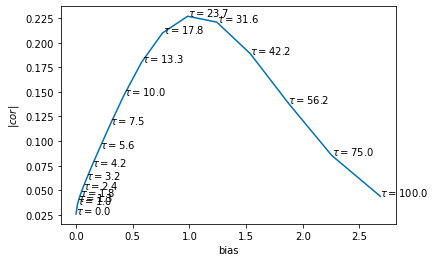

In [18]:
plt.plot(dist, cor_det_list)
plt.xlabel("bias")
plt.ylabel(r"$|cor|$")
i_D = 0
best = 0
for i, (x, y, tau) in enumerate(zip(dist, cor_det_list, tau_list)):
    plt.annotate(rf"$\tau = {tau:.1f}$", (x, y))
    if y > best:
        best = y
        i_D = i

In [19]:
# Closest to published
i_C = 0
best = np.inf
for i, (x, cov) in enumerate(zip(regularised_list, cov_list)):
    d = wasserstein(x, cov, base_x=pre_regularised_h[0], base_cov=cov_pre_regularised)
    if d < best:
        best = d
        i_C = i
    if i == i_W:
        print(i, d)
print(i_C, tau_list[i_C], best, np.sqrt(best))

13 0.34773570142544585
11 17.78279410038923 0.13675121237851862 0.36979888098602814


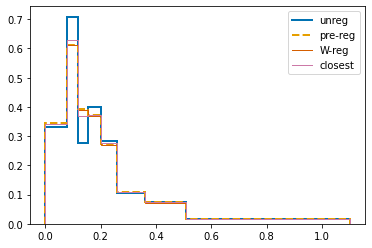

In [20]:
plt.stairs(*unfolded_h, label="unreg", linewidth=2)
plt.stairs(*pre_regularised_h, label="pre-reg", linewidth=2, linestyle="dashed")
plt.stairs(regularised_list[i_W], bins, label="W-reg")
plt.stairs(regularised_list[i_C], bins, label="closest")
plt.legend()

In [21]:
# Minimal possible plot bias
def fun(x):
    return wasserstein(unfolded_h[0], np.diag(x))


ret = minimize(fun, x0=np.diag(cov_unfolded))
best_error = np.sqrt(ret.x)

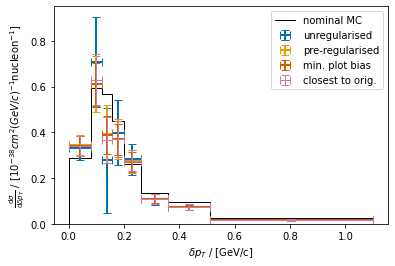

In [22]:
x = (bins[:-1] + bins[1:]) / 2
xerr = (bins[1:] - bins[:-1]) / 2

y = unfolded_h[0]
yerr = np.sqrt(np.diag(cov_unfolded))
plt.errorbar(
    x,
    y,
    yerr=yerr,
    xerr=xerr,
    label="unregularised",
    linewidth=2,
    linestyle="",
    capsize=4,
)

y = pre_regularised_h[0]
yerr = np.sqrt(np.diag(cov_pre_regularised))
plt.errorbar(
    x,
    y,
    yerr=yerr,
    xerr=xerr,
    label="pre-regularised",
    linewidth=2,
    linestyle="",
    capsize=4,
)

y = regularised_list[i_W]
yerr = np.sqrt(np.diag(cov_list[i_W]))
plt.errorbar(
    x,
    y,
    yerr=yerr,
    xerr=xerr,
    label="min. plot bias",
    linewidth=2,
    linestyle="",
    capsize=4,
)

y = regularised_list[i_C]
yerr = np.sqrt(np.diag(cov_list[i_C]))
plt.errorbar(
    x,
    y,
    yerr=yerr,
    xerr=xerr,
    label="closest to orig.",
    linewidth=1,
    linestyle="",
    capsize=4,
)

# y = unfolded_h[0]
# yerr = best_error
# plt.errorbar(
#    x, y, yerr=yerr, xerr=xerr, label="best possible", linewidth=1, linestyle="", capsize=4
# )

plt.stairs(nominal, bins, label="nominal MC")
plt.xlabel(r"$\delta p_T$ / [GeV/c]")
plt.ylabel(
    r"$\frac{\mathrm{d}\sigma}{\mathrm{d}\delta p_T}\ /\ [10^{-38} cm^2 (GeV/c)^{-1} \mathrm{nucleon}^{-1}]$"
)
plt.legend()

plt.savefig("figures/dpT.pdf")

(-0.1, 0.9505912527429026)

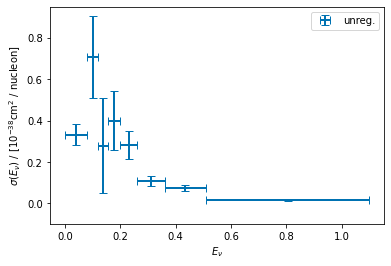

In [23]:
x = (bins[:-1] + bins[1:]) / 2
xerr = (bins[1:] - bins[:-1]) / 2

y_0 = unfolded_h[0]
y_0err = np.sqrt(np.diag(cov_unfolded))
y_reg = regularised_list[i_W]
y_err_low = y_reg - (y_0 - y_0err)
y_err_upp = (y_0 + y_0err) - y_reg


plt.errorbar(
    x,
    y_0,
    yerr=y_0err,
    xerr=xerr,
    label="unreg.",
    linewidth=2,
    linestyle="",
    capsize=4,
)

plt.legend()
plt.xlabel(r"$E_\nu$")
plt.ylabel(r"$\sigma(E_\nu)$ / [$10^{-38}$cm$^2$ / nucleon]")
plt.ylim(bottom=-0.1)

(-0.1, 0.9505912527429026)

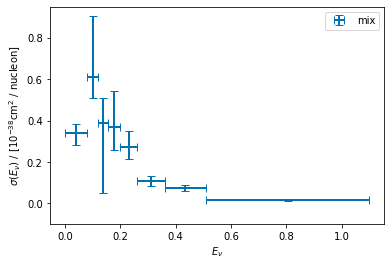

In [24]:
x = (bins[:-1] + bins[1:]) / 2
xerr = (bins[1:] - bins[:-1]) / 2

y_0 = unfolded_h[0]
y_0err = np.sqrt(np.diag(cov_unfolded))
y_reg = regularised_list[i_W]
#y_reg = pre_regularised_h[0]
y_err_low = y_reg - (y_0 - y_0err)
y_err_upp = (y_0 + y_0err) - y_reg


plt.errorbar(
    x,
    y_reg,
    yerr=(y_err_low, y_err_upp),
    xerr=xerr,
    label="mix",
    linewidth=2,
    linestyle="",
    capsize=4,
)

plt.legend()
plt.xlabel(r"$E_\nu$")
plt.ylabel(r"$\sigma(E_\nu)$ / [$10^{-38}$cm$^2$ / nucleon]")
plt.ylim(bottom=-0.1)

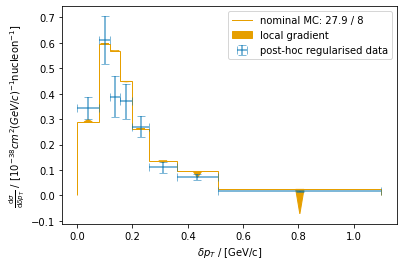

In [25]:
x = (bins[:-1] + bins[1:]) / 2
xerr = (bins[1:] - bins[:-1]) / 2

y = regularised_list[i_W]
yerr = np.sqrt(np.diag(cov_list[i_W]))
plt.errorbar(
    x,
    y,
    yerr=yerr,
    xerr=xerr,
    label="post-hoc regularised data",
    linewidth=2,
    linestyle="",
    capsize=4,
    alpha=0.5,
)

A = A_list[i_W]
reg_cov = cov_list[i_W]
reg_cov_inv = np.linalg.inv(reg_cov)
diff = y - A @ nominal
chi = diff.T @ reg_cov_inv @ diff
grad = A.T @ reg_cov_inv @ diff
# grad = cov_unfolded_inv @ (unfolded_h[0] - nominal)
# grad = np.linalg.inv(cov_unfolded[:-2,:-2]) @ (unfolded_h[0] - nominal)[:-2]
# chi = (unfolded_h[0] - nominal)[:-2].T @ grad
# grad[-1:] = 0
grad /= np.linalg.norm(grad)
grad *= 0.1

plt.stairs(nominal, bins, label=f"nominal MC: {chi:.1f} / {len(grad)}")
for ax, ay, dy in zip(x, nominal, grad):
    ar = plt.arrow(
        ax,
        ay,
        0,
        dy,
        head_width=0.03,
        length_includes_head=True,
        head_length=np.abs(dy),
        color="C1",
    )
ar.set_label(f"local gradient")

plt.xlabel(r"$\delta p_T$ / [GeV/c]")
plt.ylabel(
    r"$\frac{\mathrm{d}\sigma}{\mathrm{d}\delta p_T}\ /\ [10^{-38} cm^2 (GeV/c)^{-1} \mathrm{nucleon}^{-1}]$"
)
plt.legend()

plt.savefig("figures/dpT-gradient.pdf")

-0.2807075999364513 5.102028063406921


Text(0, 0.5, '$\\frac{\\mathrm{d}\\sigma}{\\mathrm{d}\\delta p_T}\\ /\\ \\frac{\\mathrm{d}\\sigma_\\mathrm{nominal}}{\\mathrm{d}\\delta p_T}$')

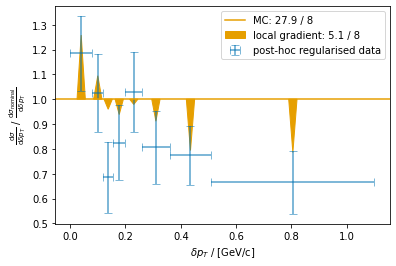

In [26]:
# data / MC
norm = nominal
ys = regularised_list[i_W] / norm
yerrs = np.sqrt(np.diag(cov_list[i_W])) / norm
plt.errorbar(
    x,
    ys,
    yerr=yerrs,
    xerr=xerr,
    label="post-hoc regularised data",
    linewidth=2,
    linestyle="",
    capsize=4,
    alpha=0.5,
)

model = nominal
chi = utils.chi2(model, unfolded_h[0], cov_unfolded_inv)
grad = utils.scaled_grad(norm, model, unfolded_h[0], cov_unfolded_inv)
chi_grad = utils.chi2(model * (grad + 1.0), unfolded_h[0], cov_unfolded_inv)
print(np.sum(grad), chi_grad)
ys = model / norm
# plt.stairs(ys, bins, baseline=None, color="C1")
plt.axhline(1.0, color="C1", label=f"MC: {chi:.1f} / {len(model)}")
hw = np.min(xerr)
for ax, ay, dy in zip(x, ys, grad):
    ar = plt.arrow(
        ax,
        ay,
        0,
        dy,
        head_width=0.03,
        length_includes_head=True,
        head_length=np.abs(dy),
        color="C1",
    )
ar.set_label(f"local gradient: {chi_grad:.1f} / {len(model)}")

plt.legend()
plt.xlabel(r"$\delta p_T$ / [GeV/c]")
plt.ylabel(
    r"$\frac{\mathrm{d}\sigma}{\mathrm{d}\delta p_T}\ /\ \frac{\mathrm{d}\sigma_\mathrm{nominal}}{\mathrm{d}\delta p_T}$"
)

-0.2807075999548549 5.102028063406921


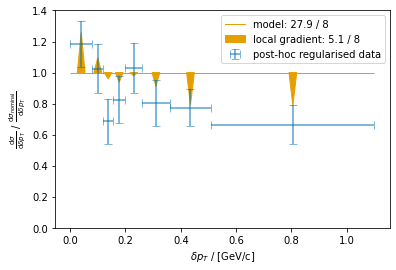

In [27]:
utils.model_ratio_plot(
    model, regularised_list[i_W], cov_list[i_W], A_list[i_W], bins=bins, data_label="post-hoc regularised data"
)
plt.xlabel(r"$\delta p_T$ / [GeV/c]")
plt.ylabel(
    r"$\frac{\mathrm{d}\sigma}{\mathrm{d}\delta p_T}\ /\ \frac{\mathrm{d}\sigma_\mathrm{nominal}}{\mathrm{d}\delta p_T}$"
)

plt.savefig("figures/dpT-ratio.pdf")